In [1]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [2]:
import torch
import torch.utils.data
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 50000张训练图片
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=36,
                                          shuffle=True, num_workers=0)

# 10000张测试图片
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False, num_workers=0)
test_data_iter = iter(testloader)
test_image, test_label = test_data_iter.next()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
net = LeNet()       # 导入模型
loss_function = nn.CrossEntropyLoss()        # 定义损失函数
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [4]:
for epoch in range(5):          # 迭代多少次，这里迭代了5次。

    running_loss = 0.0          # 累加训练过程中的损失。
    for step,data in enumerate(trainloader, start=0):         # 通过循环来便利我们的训练集样本。通过enumerate能返回每一批训练的data以及data所对应的步数
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        optimizer.zero_grad()    # 通过这个函数将历史损失函数清零

        outputs = net(inputs)        # 计算输出
        loss = loss_function(outputs, labels)         # 计算损失
        loss.backward()        # loss反向传播
        optimizer.step()       # 进行参数更新

        running_loss += loss.item()         # 每次loss计算完后累加到running_loss变量中
        if step % 500 == 499:               # 每训练500步打印训练的信息
            with torch.no_grad():           # 不用在测试过程中计算损失梯度
                outputs = net(test_image)   # 正向传播
                predict_y = torch.max(outputs, dim=1)[1]       # 寻找对象最可能归于哪个类别，在维度1上寻找最大值。[1]表示只需要知道index，不需要知道最大值为多少。
                accuracy = (predict_y == test_label).sum().item() / test_label.size(0)   # 将预测的标签类别与真实的标签类别进行比较。
                # 通过sum求和函数预测在本次测试中预测对了多少样本。item函数拿到对应的数值，再除以测试样本的数目，得到准确率。

                print('[%d, %5d] train_loss: %.3f  test_accuracy: %.3f' %
                      (epoch + 1, step + 1, running_loss / 500, accuracy))
                # %d对应epoch，指迭代第几轮；%5d对应step，指某一轮的多少步；%.3f对应running_loss，指训练过程中的误差。
                running_loss = 0.0

print('Finished Training')

save_path = './Lenet.pth'
torch.save(net.state_dict(), save_path)

[1,   500] train_loss: 1.740  test_accuracy: 0.455
[1,  1000] train_loss: 1.440  test_accuracy: 0.523
[2,   500] train_loss: 1.197  test_accuracy: 0.580
[2,  1000] train_loss: 1.162  test_accuracy: 0.607
[3,   500] train_loss: 1.024  test_accuracy: 0.635
[3,  1000] train_loss: 0.990  test_accuracy: 0.649
[4,   500] train_loss: 0.906  test_accuracy: 0.660
[4,  1000] train_loss: 0.899  test_accuracy: 0.640
[5,   500] train_loss: 0.829  test_accuracy: 0.680
[5,  1000] train_loss: 0.830  test_accuracy: 0.680
Finished Training


In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image


transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 根据LeNetmodel中LeNet设置的参数为图像大小32*32将原图通过resize进行缩放。其余参考LeNetmodel中注释。

classes = ('plane', 'car', 'bird', 'cat',                                     # 用classes函数将标签导入，此处为元组类型(值不能改变)。*注意：index0对应的是plane。
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

net = LeNet()
net.load_state_dict(torch.load('Lenet.pth'))                 # 载入权重文件

im = Image.open('2.jpg')
im = transform(im)              # 得到了[C,H,W]的格式
im = torch.unsqueeze(im, dim=0)           # 增加一个新的维度，此事为[N,C,H,W]

with torch.no_grad():
    outputs = net(im)
    predict = torch.max(outputs, dim=1)[1].data.numpy()
print(classes[int(predict)])

horse


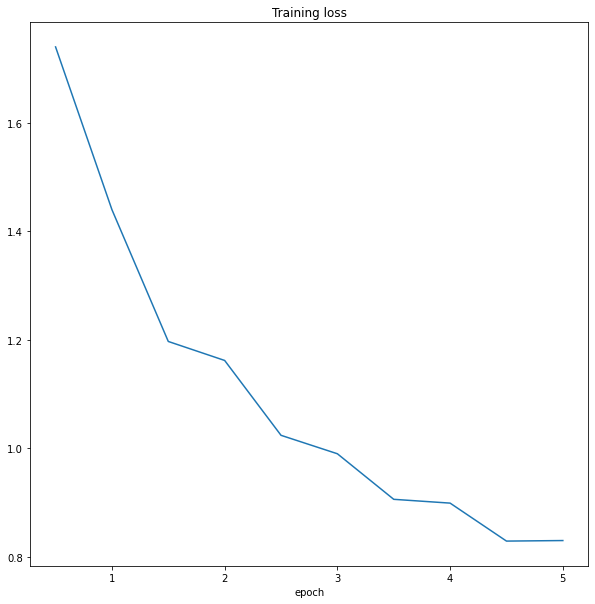

In [6]:
plt.figure(figsize=(10,10))
x = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
y0 = [1.740, 1.440, 1.197, 1.162, 1.024, 0.990, 0.906, 0.899, 0.829, 0.830]
plt.title('Training loss')
plt.xlabel('epoch')
plt.plot(x, y0)
plt.show()

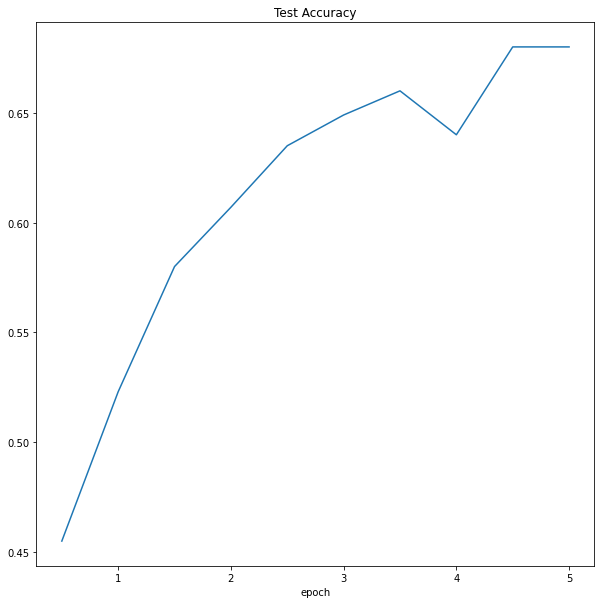

In [7]:
plt.figure(figsize=(10,10))
x = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
y1 = [0.455, 0.523, 0.580, 0.607, 0.635, 0.649, 0.660, 0.640, 0.680, 0.680]
plt.title('Test Accuracy')
plt.xlabel('epoch')
plt.plot(x, y1)
plt.show()